In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import os,re
from imblearn.under_sampling import NearMiss

In [53]:
!ls {data_dir}/reduced_datasets/averaged

1_ClusterCentroids_banana_0.05.csv     3_NearMiss-2_pima_0.2.csv
1_ClusterCentroids_banana_0.1.csv      3_NearMiss-2_pima_0.3.csv
1_ClusterCentroids_banana_0.2.csv      3_NearMiss-2_pima_0.4.csv
1_ClusterCentroids_banana_0.3.csv      3_NearMiss-2_pima_0.5.csv
1_ClusterCentroids_banana_0.4.csv      3_NearMiss-2_ring_0.05.csv
1_ClusterCentroids_banana_0.5.csv      3_NearMiss-2_ring_0.1.csv
1_ClusterCentroids_bupa_0.05.csv       3_NearMiss-2_ring_0.2.csv
1_ClusterCentroids_bupa_0.1.csv        3_NearMiss-2_ring_0.3.csv
1_ClusterCentroids_bupa_0.2.csv        3_NearMiss-2_ring_0.4.csv
1_ClusterCentroids_bupa_0.3.csv        3_NearMiss-2_ring_0.5.csv
1_ClusterCentroids_bupa_0.4.csv        3_NearMiss-2_twonorm_0.05.csv
1_ClusterCentroids_bupa_0.5.csv        3_NearMiss-2_twonorm_0.1.csv
1_ClusterCentroids_magic_0.05.csv      3_NearMiss-2_twonorm_0.2.csv
1_ClusterCentroids_magic_0.1.csv       3_NearMiss-2_twonorm_0.3.csv
1_ClusterCentroids_magic_0.2.csv       3_NearMiss-2_twonorm_0.4.csv
1_Cluste

In [176]:
regex_pattern = r'pattern_\d+\.txt'  # Replace this with your desired regular expression pattern
input_files= ["banana","bupa" , "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
# input_files= ["bupa" , "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
data_dir='xsetin00/Data'
reduced_data_dir=f'{data_dir}/reduced_datasets/averaged'

methods_to_drop=["bouldin_tree","clustercentroids"]
datasets={}
for i in input_files:
    regex_pattern=r'^.*'+i+r'.*$'
    datasets[i]={"train":{},"test":{}}
    for fold in range(1,6):
        datasets[i]["train"][str(fold)]=[]
    # Iterate through the files in the source directory
    for filename in os.listdir(reduced_data_dir):
        
        # Check if the file matches the regular expression pattern
        if re.match(regex_pattern, filename):
            if filename[2:6]=="test":
                datasets[i]["test"][filename[0]]=filename
            else:
                if re.match(r'^.*'+methods_to_drop[0]+r'.*$', filename): continue #or re.match(r'^.*'+methods_to_drop[1]+r'.*$', filename): continue
                datasets[i]["train"][filename[0]].append(filename)

print(len(datasets["banana"]["train"]["1"]))
print(datasets["banana"]["test"])
#print(datasets)

49
{'3': '3_test_banana.csv', '1': '1_test_banana.csv', '5': '5_test_banana.csv', '4': '4_test_banana.csv', '2': '2_test_banana.csv'}


In [3]:
def drop_duplicates(X,amount):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    neighbor_pairs = []
    for i in range(len(X)):
        distance = distances[i][1]  # 
        neighbor_index = indices[i][1]  #
        neighbor_pairs.append((i, neighbor_index, distance))
    neighbor_pairs.sort(key=lambda x: x[2])
    #print("original size",len(neighbor_pairs))
    points_to_drop = []
    for row in neighbor_pairs:
        _, neighbour, _ = row
        if neighbour not in points_to_drop:
            points_to_drop.append(neighbour)
    points_to_drop=points_to_drop[:(X.shape[0]-amount)]         
    #print("to drop",len(points_to_drop))

    return pd.DataFrame(np.delete(X, points_to_drop, axis=0),columns=X.columns)

In [177]:
database=pd.read_csv(f'{reduced_data_dir}/new_format_gridsearch.csv')

In [164]:
print(database.to_string())

      Dataset   RED              Method       ACC Model  Fold
0      banana  0.90          NearMiss-2  0.728302    DT     1
1      banana  0.90          NearMiss-2  0.640566    RF     1
2      banana  0.90          NearMiss-2  0.639623    NN     1
3      banana  0.90          NearMiss-2  0.707547   KNN     1
4      banana  0.95          NearMiss-2  0.588679    DT     1
5      banana  0.95          NearMiss-2  0.635849    RF     1
6      banana  0.95          NearMiss-2  0.585849    NN     1
7      banana  0.95          NearMiss-2  0.598113   KNN     1
8      banana  0.80         Grouped_1NN  0.791509    DT     1
9      banana  0.80         Grouped_1NN  0.913208    RF     1
10     banana  0.80         Grouped_1NN  0.906604    NN     1
11     banana  0.80         Grouped_1NN  0.884906   KNN     1
12     banana  0.70          NearMiss-2  0.757547    DT     1
13     banana  0.70          NearMiss-2  0.714151    RF     1
14     banana  0.70          NearMiss-2  0.729245    NN     1
15     b

GridSearch

In [71]:
grids={
    "RF":{
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
        'criterion': ['gini', 'entropy']  # Split criterion
    },
    "KNN":{
        'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
        'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors ('uniform' or 'distance')
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for nearest neighbor search
        'p': [1, 2]  # Parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
    },
    "DT":{
        'criterion': ['gini', 'entropy'],  # Split criterion
        'splitter': ['best', 'random'],  # Strategy for splitting nodes
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt', 'log2', None]  # Number of features to consider at each split
    },
    "NN":{
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],  # Size and structure of hidden layers
        'activation': ['relu', 'logistic', 'tanh'],  # Activation function for hidden layers
        'solver': ['adam', 'sgd'],  # Optimization algorithm
        'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
        'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
        'max_iter': [100, 200, 300],  # Maximum number of iterations
    }

    }


In [73]:
best_models=dict(zip(input_files,[{} for _ in range(len(input_files))]))
models=[(DecisionTreeClassifier(),"DT"),
        (RandomForestClassifier(),"RF"),
        (MLPClassifier(),"NN"),
        (KNeighborsClassifier(),"KNN")]

for filename in input_files:
    print(filename)
    refdata=pd.read_csv(os.path.join(data_dir,"refdata_prepared",f"{filename}.csv"))
    X=refdata.drop(columns=["Class"])
    y=refdata["Class"]
    for model in models:
        grid_search = GridSearchCV(model[0], grids[model[1]], cv=5, scoring='accuracy', n_jobs=-1,verbose=1)
        grid_search.fit(X, y)
        best_models[filename][model[1]]=grid_search
    #print(X.shape)
    
joblib.dump(best_models,os.path.join(data_dir,"best_models.pkl"))   

    

banana
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

['xsetin00/Data/best_models.pkl']

In [165]:
best_models=joblib.load(os.path.join(data_dir,"best_models.pkl"))
best_models

{'banana': {'DT': GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
               param_grid={'criterion': ['gini', 'entropy'],
                           'max_depth': [None, 10, 20, 30],
                           'max_features': ['auto', 'sqrt', 'log2', None],
                           'min_samples_leaf': [1, 2, 4],
                           'min_samples_split': [2, 5, 10],
                           'splitter': ['best', 'random']},
               scoring='accuracy', verbose=1),
  'RF': GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
               param_grid={'bootstrap': [True, False],
                           'criterion': ['gini', 'entropy'],
                           'max_depth': [None, 10, 20, 30],
                           'max_features': ['auto', 'sqrt', 'log2'],
                           'min_samples_leaf': [1, 2, 4],
                           'min_samples_split': [2, 5, 10],
                           'n_estimators': [100, 200, 300]

In [44]:
params=best_models["banana"][models[0]].best_params_
to_save=pd.Series(params)
# save dict to csv file
print(dict(to_save))
to_save.to_csv(f"{data_dir}/banana_best_params.csv",header=False)
loaded_params=pd.read_csv(f"{data_dir}/banana_best_params.csv",header=None)
print(dict(loaded_params))
tree=DecisionTreeClassifier(**best_models["banana"][models[0]].best_params_)

{'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
{0: 0            criterion
1            max_depth
2         max_features
3     min_samples_leaf
4    min_samples_split
5             splitter
Name: 0, dtype: object, 1: 0      gini
1        30
2       NaN
3         4
4         2
5    random
Name: 1, dtype: object}


In [178]:
# models=[(DecisionTreeClassifier(random_state=0),"DT"),
#     (RandomForestClassifier(max_depth=5,random_state=0),"RF"),
#     (MLPClassifier(random_state=0),"NN"),
#     (KNeighborsClassifier(n_neighbors=3),"KNN")]

data_to_visualize=pd.DataFrame()

for dataset in datasets:
    for fold in range(1,6):
        print(fold)
        csv_test_data=pd.read_csv(os.path.join(reduced_data_dir,datasets[dataset]["test"][str(fold)]))
        y_test=csv_test_data["Class"]
        X_test=csv_test_data.drop("Class",axis=1)
        print(X_test.shape) 
        index_old=datasets[dataset]["train"][str(fold)].index(f"{str(fold)}_old_{dataset}_0.0.csv")
        old_train_data=pd.read_csv(os.path.join(reduced_data_dir,datasets[dataset]["train"][str(fold)][index_old]))
        old_size=old_train_data.shape[0]
        for train_data_name in datasets[dataset]["train"][str(fold)]:
            
           
            metadata=train_data_name.split("_")
            
            red=metadata[-1][:-4]
            method=metadata[1]+"_"+metadata[2] if metadata[1] == "bouldin" else metadata[1]
            if (len(metadata)>4) and (metadata[4][-1] == "n"):
                method=method+"_"+metadata[4]
            
            if method == "old":
                method="Old"
            if method == "grouped":
                method="Grouped_1NN"
            
            if database.shape[0] != 0:
                if ((database['Method'] == method) & (database['Fold'] == fold) & (database['Dataset'] == dataset)).any(): 
                    print("already done")
                    continue
            print(train_data_name)
            print(metadata)
            print(method,red)
            csv_train_data=pd.read_csv(os.path.join(reduced_data_dir,train_data_name))
            original_size=csv_train_data.shape[0]
            if original_size == 0: continue
            if train_data_name[:5] == "mixed" or metadata[1] == "random":
                continue
                # print(train_data_name)
                # csv_train_data=csv_train_data.drop_duplicates()
                # red=float(red)*(csv_train_data.shape[0]/original_size)
            #csv_train_data=csv_train_data.drop_duplicates()
            y_train=csv_train_data["Class"]
            X_train=csv_train_data.drop("Class",axis=1)
            if method == "Grouped_1NN":
                style="1NN_class_sens"
                amount=int(old_size*float(red)*0.5)
                print("to extract",amount)
                csv_train_data=csv_train_data.drop_duplicates()
                if style == "nearmiss":
                    for i in range(1,4):
                        sampler = NearMiss(sampling_strategy={0:amount,1:amount},version=i,n_jobs=-1)
                        X_train_red, y_train_red = sampler.fit_resample(X_train, y_train)
                        #print(X_train_red.shape)
                        for model in best_models[dataset]:
                            
                            best_models[dataset][model].best_estimator_.fit(X_train_red,y_train_red)
                            try:
                                y_pred=best_models[dataset][model].best_estimator_.predict(X_test)    
                            except:
                                continue
                            acc=accuracy_score(y_test,y_pred)
                            #print(acc)
                            df=pd.DataFrame({"Dataset":dataset,
                                                "RED":red,
                                                "Method":f"{method}_{style}_{i}",
                                                "ACC":acc,
                                                "Model":model,
                                                "Fold":fold},
                                                index=[0])

                            data_to_visualize=pd.concat([data_to_visualize,df],ignore_index=True)
                else: # drop 1nn neighbours
                    posX=X_train[y_train==1]
                    posy=y_train[y_train==1]
                    negX=X_train[y_train==0]
                    negy=y_train[y_train==0]
                    X_train_red=pd.DataFrame()
                    for X,y in [(posX,posy),(negX,negy)]:
                        class_red=drop_duplicates(X,amount)
                        while class_red.shape[0] != amount: 
                            class_red=drop_duplicates(class_red,amount)
                            print("extracted",class_red.shape[0])
                        X_train_red=pd.concat([X_train_red,class_red])
                    X_train_red.reset_index(drop=True,inplace=True)
                    #print(X_train_red)
                    #X_train_red=np.array(X_train_red)    
                    print(X_train_red.shape)
                    # take first n elements of y
                    y_train_red = pd.concat([posy[:amount],negy[:amount]])   
                    for model in best_models[dataset]:
                        
                        best_models[dataset][model].best_estimator_.fit(X_train_red,y_train_red)
                        try:
                            y_pred=best_models[dataset][model].best_estimator_.predict(X_test)    
                        except:
                            continue
                        acc=accuracy_score(y_test,y_pred)
                        print(acc)
                        df=pd.DataFrame({"Dataset":dataset,
                                            "RED":red,
                                            "Method":f"{method}",
                                            "ACC":acc,
                                            "Model":model,
                                            "Fold":fold},
                                            index=[0])

                        data_to_visualize=pd.concat([data_to_visualize,df],ignore_index=True)
            else:    
                print(X_train.shape)
                for model in best_models[dataset]:
                    
                    best_models[dataset][model].best_estimator_.fit(X_train,y_train)
                    try:
                        y_pred=best_models[dataset][model].best_estimator_.predict(X_test)    
                    except:
                        continue
                    acc=accuracy_score(y_test,y_pred)
                    print(acc)
                    df=pd.DataFrame({"Dataset":dataset,
                                        "RED":red,
                                        "Method":method,
                                        "ACC":acc,
                                        "Model":model,
                                        "Fold":fold},
                                        index=[0])

                    data_to_visualize=pd.concat([data_to_visualize,df],ignore_index=True)
            

print(data_to_visualize)
joblib.dump(data_to_visualize,os.path.join(data_dir,"data_to_visualize.pkl"))

1
(1060, 2)
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
2
(1060, 2)
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
already done
a

['xsetin00/Data/data_to_visualize.pkl']

In [167]:
#data_to_visualize=data_to_visualize[data_to_visualize["Method"]=="bouldin_3NN"]
print(data_to_visualize.to_string())

     Dataset   RED Method       ACC Model  Fold
0     banana   0.3    IRB  0.872642    DT     1
1     banana   0.3    IRB  0.894340    RF     1
2     banana   0.3    IRB  0.891509    NN     1
3     banana   0.3    IRB  0.890566   KNN     1
4     banana   0.1    IRB  0.536792    DT     1
5     banana   0.1    IRB  0.256604    RF     1
6     banana   0.1    IRB  0.500943    NN     1
7     banana   0.1    IRB  0.281132   KNN     1
8     banana  0.05    IRB  0.274528    DT     1
9     banana  0.05    IRB  0.333019    RF     1
10    banana  0.05    IRB  0.416038    NN     1
11    banana  0.05    IRB  0.277358   KNN     1
12    banana   0.5    IRB  0.897170    DT     1
13    banana   0.5    IRB  0.932075    RF     1
14    banana   0.5    IRB  0.911321    NN     1
15    banana   0.5    IRB  0.912264   KNN     1
16    banana   0.2    IRB  0.605660    DT     1
17    banana   0.2    IRB  0.465094    RF     1
18    banana   0.2    IRB  0.609434    NN     1
19    banana   0.2    IRB  0.569811   KN

1_IRBBEST_banana_0.5.csv
(2119, 3)


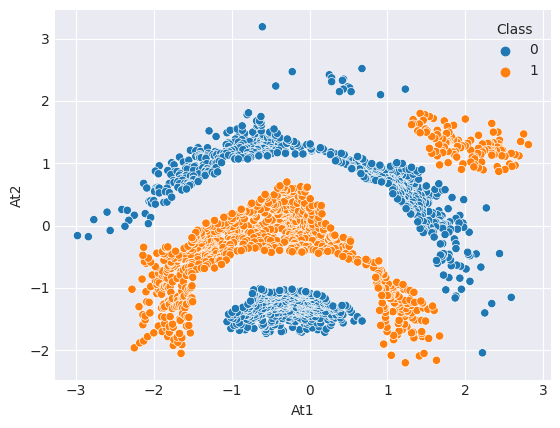

1_IRB_banana_0.5.csv
(2120, 3)


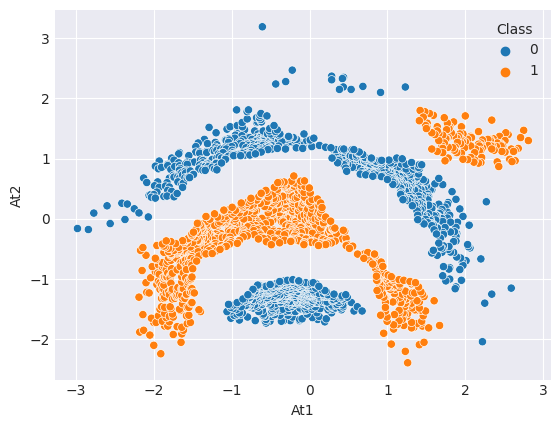

<Axes: xlabel='At1', ylabel='At2'>

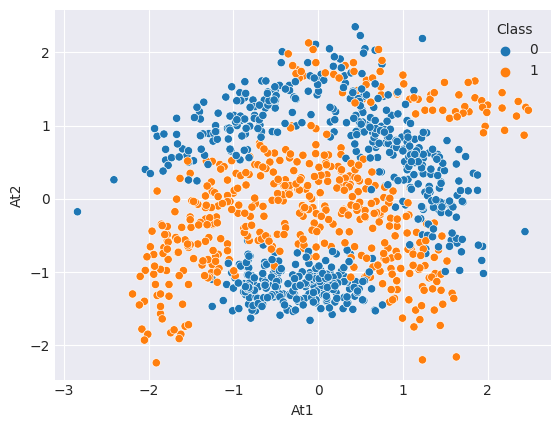

In [145]:
train_files=datasets["banana"]["train"]["1"]
test_file="1_test_banana.csv"
train_files.sort()

features=["At1","At2"]
i="IRB"
for train_file in train_files:
    if re.match(r'^.*'+i+r'.*0.5.*$', train_file): #
        csv_data= pd.read_csv(f'{reduced_data_dir}/{train_file}')
        sns.scatterplot(data=csv_data, x=features[0], y=features[1], hue="Class")
        print(train_file)
        print(csv_data.shape)
        plt.show()

test_df = pd.read_csv(f'{reduced_data_dir}/{datasets["banana"]["test"]["1"]}')
sns.scatterplot(data=test_df, x=features[0], y=features[1], hue="Class")
# y_test=test_df["Class"]
# X_test=test_df.drop("Class",axis=1)
# X_test=X_test[features]
# pca=PCA(n_components=2)
#X_test=pca.fit_transform(X_test)



In [25]:

for data in train_dfs.values():
    
    knn=KNeighborsClassifier(n_neighbors=3)#KNeighborsClassifier(n_neighbors=3)#DecisionTreeClassifier(random_state=0)##KNeighborsClassifier(n_neighbors=3)#MLPClassifier(random_state=1, max_iter=300)#RandomForestClassifier(max_depth=2, random_state=0)#DecisionTreeClassifier(random_state=0)#
    # print(data)
    y_train=data["Class"]
    X_train=data.drop("Class",axis=1)
    #X_train=pca.transform(X_train)
    X_train=X_train[features]
    #print(X_train,y_train)
    # plot_data=pd.concat([pd.DataFrame(X_train),y_train],axis=1)
    # print(plot_data)
    # sns.scatterplot(data=plot_data, x=0, y=1, hue="Class")
    # plt.show()
    # Create an explainer object
   

    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    print(classification_report(y_test,y_pred))
    # explainer = shap.Explainer(knn.predict, X_train)

    # # Calculate SHAP values for your dataset
    # shap_values = explainer(X_train)

    # shap.summary_plot(shap_values, X_train)

    misclassified_indices = y_pred != y_test
    misclassified_X = X_test[misclassified_indices]
    misclassified_y_pred = y_pred[misclassified_indices]
    misclassified_y_actual = y_test[misclassified_indices]

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       706
           1       0.67      0.72      0.70       774

    accuracy                           0.67      1480
   macro avg       0.67      0.67      0.67      1480
weighted avg       0.67      0.67      0.67      1480

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       706
           1       0.71      0.53      0.60       774

    accuracy                           0.64      1480
   macro avg       0.65      0.64      0.64      1480
weighted avg       0.65      0.64      0.63      1480



VISUALIZATION of accuracy with different models

In [171]:
new_format=data_to_visualize

# filter dataframe

new_format.RED=pd.to_numeric(new_format.RED)
new_format = new_format[(new_format['RED'] < 0.02) | (new_format['RED'] >0.04)]

# use lambda to modify series
new_format['RED'] = new_format['RED'].apply(lambda x: 1-x if x != 0 else 0)

print(new_format)

     Dataset   RED Method       ACC Model  Fold
0     banana  0.70    IRB  0.872642    DT     1
1     banana  0.70    IRB  0.894340    RF     1
2     banana  0.70    IRB  0.891509    NN     1
3     banana  0.70    IRB  0.890566   KNN     1
4     banana  0.90    IRB  0.536792    DT     1
..       ...   ...    ...       ...   ...   ...
955  phoneme  0.60    IRB  0.868640   KNN     5
956  phoneme  0.95    IRB  0.535615    DT     5
957  phoneme  0.95    IRB  0.547641    RF     5
958  phoneme  0.95    IRB  0.635523    NN     5
959  phoneme  0.95    IRB  0.555042   KNN     5

[960 rows x 6 columns]


In [26]:
print(new_format.to_string())

     Dataset   RED              Method       ACC Model  Fold
0     banana  0.90          NearMiss-2  0.728302    DT     1
1     banana  0.90          NearMiss-2  0.640566    RF     1
2     banana  0.90          NearMiss-2  0.639623    NN     1
3     banana  0.90          NearMiss-2  0.707547   KNN     1
4     banana  0.95          NearMiss-2  0.588679    DT     1
5     banana  0.95          NearMiss-2  0.635849    RF     1
6     banana  0.95          NearMiss-2  0.585849    NN     1
7     banana  0.95          NearMiss-2  0.598113   KNN     1
8     banana  0.80         Grouped_1NN  0.791509    DT     1
9     banana  0.80         Grouped_1NN  0.913208    RF     1
10    banana  0.80         Grouped_1NN  0.906604    NN     1
11    banana  0.80         Grouped_1NN  0.884906   KNN     1
12    banana  0.70          NearMiss-2  0.757547    DT     1
13    banana  0.70          NearMiss-2  0.714151    RF     1
14    banana  0.70          NearMiss-2  0.729245    NN     1
15    banana  0.70      

In [172]:
new_format=pd.concat([database,new_format],axis=0)


In [205]:
new_format.replace({"Grouped_1NN_1NN_class_sens": "Grouped_1NN","old":"Old"},inplace=True)

In [173]:
print(new_format.to_string())

      Dataset   RED              Method       ACC Model  Fold
0      banana  0.90          NearMiss-2  0.728302    DT     1
1      banana  0.90          NearMiss-2  0.640566    RF     1
2      banana  0.90          NearMiss-2  0.639623    NN     1
3      banana  0.90          NearMiss-2  0.707547   KNN     1
4      banana  0.95          NearMiss-2  0.588679    DT     1
5      banana  0.95          NearMiss-2  0.635849    RF     1
6      banana  0.95          NearMiss-2  0.585849    NN     1
7      banana  0.95          NearMiss-2  0.598113   KNN     1
8      banana  0.80         Grouped_1NN  0.791509    DT     1
9      banana  0.80         Grouped_1NN  0.913208    RF     1
10     banana  0.80         Grouped_1NN  0.906604    NN     1
11     banana  0.80         Grouped_1NN  0.884906   KNN     1
12     banana  0.70          NearMiss-2  0.757547    DT     1
13     banana  0.70          NearMiss-2  0.714151    RF     1
14     banana  0.70          NearMiss-2  0.729245    NN     1
15     b

In [181]:
# new_format.RED=new_format.RED.apply(str)
tmp=new_format.drop(columns=["Fold"]).groupby(["Dataset","Method","Model","RED"]).mean()
tmp.reset_index(inplace=True)
print(tmp.to_string())
new_format=tmp

      Dataset              Method Model   RED       ACC
0      banana    ClusterCentroids    DT  0.50  0.885472
1      banana    ClusterCentroids    DT  0.60  0.800000
2      banana    ClusterCentroids    DT  0.70  0.815849
3      banana    ClusterCentroids    DT  0.80  0.846792
4      banana    ClusterCentroids    DT  0.90  0.842830
5      banana    ClusterCentroids    DT  0.95  0.766604
6      banana    ClusterCentroids   KNN  0.50  0.901698
7      banana    ClusterCentroids   KNN  0.60  0.903019
8      banana    ClusterCentroids   KNN  0.70  0.903208
9      banana    ClusterCentroids   KNN  0.80  0.899245
10     banana    ClusterCentroids   KNN  0.90  0.900000
11     banana    ClusterCentroids   KNN  0.95  0.901321
12     banana    ClusterCentroids    NN  0.50  0.904717
13     banana    ClusterCentroids    NN  0.60  0.903019
14     banana    ClusterCentroids    NN  0.70  0.901509
15     banana    ClusterCentroids    NN  0.80  0.901698
16     banana    ClusterCentroids    NN  0.90  0

In [174]:
# save to csv
new_format.to_csv(f"{reduced_data_dir}/new_format_gridsearch.csv",index=False)

In [179]:
range_data=database

In [126]:
database

Dataset   RED      Method       ACC Model  Fold
0      banana  0.90  NearMiss-2  0.728302    DT     1
1      banana  0.90  NearMiss-2  0.640566    RF     1
2      banana  0.90  NearMiss-2  0.639623    NN     1
3      banana  0.90  NearMiss-2  0.707547   KNN     1
4      banana  0.95  NearMiss-2  0.588679    DT     1
...       ...   ...         ...       ...   ...   ...
8745  phoneme  0.95         IRB  0.483811   KNN     5
8746  phoneme  0.50     IRBBEST  0.784459    DT     5
8747  phoneme  0.50     IRBBEST  0.791859    RF     5
8748  phoneme  0.50     IRBBEST  0.813136    NN     5
8749  phoneme  0.50     IRBBEST  0.794635   KNN     5

[8750 rows x 6 columns]

/tmp/ipykernel_1351/3786171780.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


['DT' 'KNN' 'NN' 'RF']
                  Method       ACC  Fold
2108    ClusterCentroids  0.865931     3
2456    ClusterCentroids  0.864090     5
2348    ClusterCentroids  0.857781     4
1808    ClusterCentroids  0.863302     1
2012    ClusterCentroids  0.854101     2
1796         Grouped_1NN  0.802576     1
2332         Grouped_1NN  0.827550     4
2508         Grouped_1NN  0.813617     5
2148         Grouped_1NN  0.820189     3
2056         Grouped_1NN  0.796530     2
7154                 IRB  0.777077     4
7186                 IRB  0.804154     5
7130                 IRB  0.768927     3
7110                 IRB  0.787066     2
7078                 IRB  0.809411     1
1952          NearMiss-1  0.735016     2
2408          NearMiss-1  0.739222     5
2388          NearMiss-1  0.750526     4
2116          NearMiss-1  0.726078     3
1800          NearMiss-1  0.771556     1
1960          NearMiss-2  0.632492     2
1852          NearMiss-2  0.648265     1
2268          NearMiss-2  0.643533

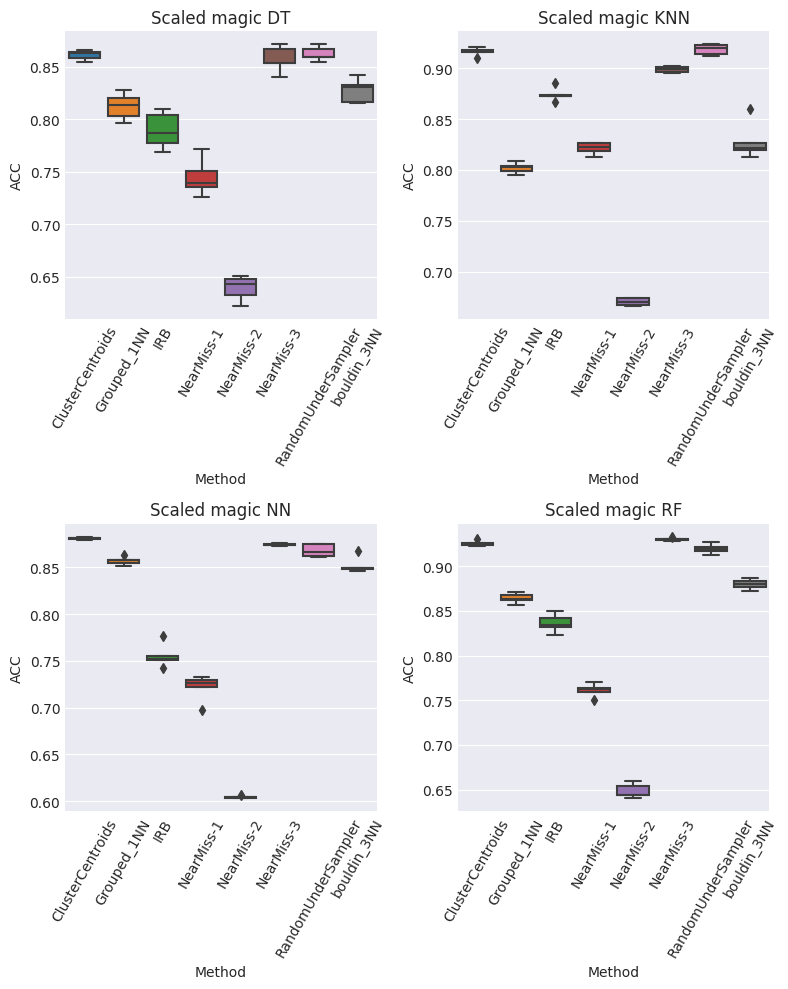

                  Method       ACC  Fold
232     ClusterCentroids  0.877358     2
512     ClusterCentroids  0.887736     3
776     ClusterCentroids  0.879245     5
540     ClusterCentroids  0.898113     4
52      ClusterCentroids  0.884906     1
112          Grouped_1NN  0.885849     1
556          Grouped_1NN  0.830189     4
424          Grouped_1NN  0.851887     3
336          Grouped_1NN  0.842453     2
704          Grouped_1NN  0.854717     5
6842                 IRB  0.897170     1
6862                 IRB  0.869811     2
6922                 IRB  0.902830     4
6878                 IRB  0.876415     3
6926                 IRB  0.893396     5
712           NearMiss-1  0.880189     5
88            NearMiss-1  0.885849     1
192           NearMiss-1  0.845283     2
392           NearMiss-1  0.753774     3
572           NearMiss-1  0.857547     4
816           NearMiss-2  0.817925     5
592           NearMiss-2  0.830189     4
488           NearMiss-2  0.798113     3
140           Ne

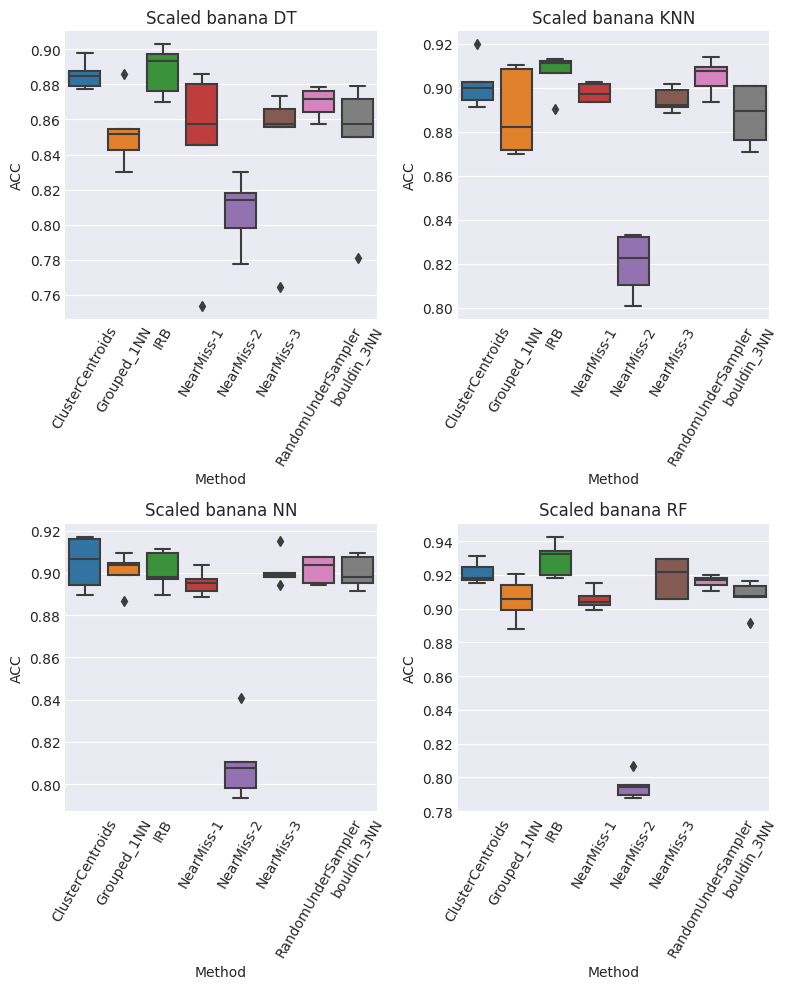

                  Method       ACC  Fold
900     ClusterCentroids  0.666667     1
1568    ClusterCentroids  0.768116     5
1064    ClusterCentroids  0.652174     2
1396    ClusterCentroids  0.652174     4
1288    ClusterCentroids  0.521739     3
916          Grouped_1NN  0.536232     1
1632         Grouped_1NN  0.579710     5
1420         Grouped_1NN  0.492754     4
1060         Grouped_1NN  0.594203     2
1280         Grouped_1NN  0.550725     3
7014                 IRB  0.681159     3
6994                 IRB  0.782609     2
6970                 IRB  0.637681     1
7034                 IRB  0.739130     4
7050                 IRB  0.666667     5
1260          NearMiss-1  0.666667     3
968           NearMiss-1  0.695652     1
1600          NearMiss-1  0.666667     5
1480          NearMiss-1  0.652174     4
1096          NearMiss-1  0.739130     2
1708          NearMiss-2  0.666667     5
1000          NearMiss-2  0.623188     1
1488          NearMiss-2  0.521739     4
1316          Ne

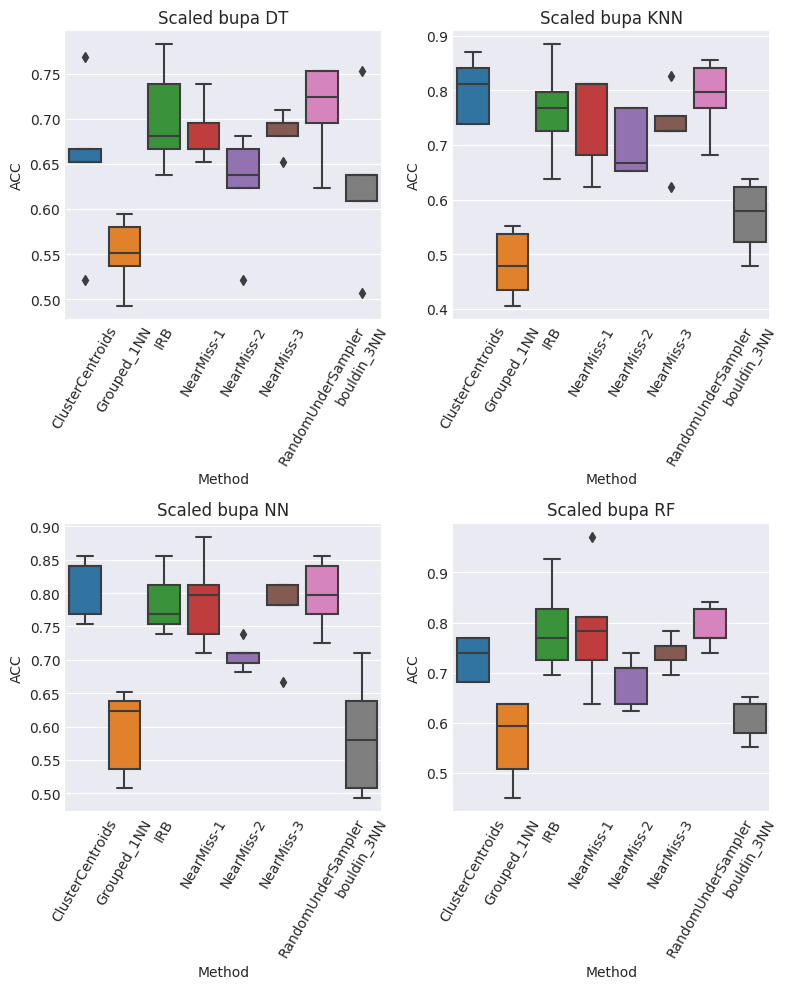

                  Method       ACC  Fold
2108    ClusterCentroids  0.865931     3
2456    ClusterCentroids  0.864090     5
2348    ClusterCentroids  0.857781     4
1808    ClusterCentroids  0.863302     1
2012    ClusterCentroids  0.854101     2
1796         Grouped_1NN  0.802576     1
2332         Grouped_1NN  0.827550     4
2508         Grouped_1NN  0.813617     5
2148         Grouped_1NN  0.820189     3
2056         Grouped_1NN  0.796530     2
7154                 IRB  0.777077     4
7186                 IRB  0.804154     5
7130                 IRB  0.768927     3
7110                 IRB  0.787066     2
7078                 IRB  0.809411     1
1952          NearMiss-1  0.735016     2
2408          NearMiss-1  0.739222     5
2388          NearMiss-1  0.750526     4
2116          NearMiss-1  0.726078     3
1800          NearMiss-1  0.771556     1
1960          NearMiss-2  0.632492     2
1852          NearMiss-2  0.648265     1
2268          NearMiss-2  0.643533     4
2096          Ne

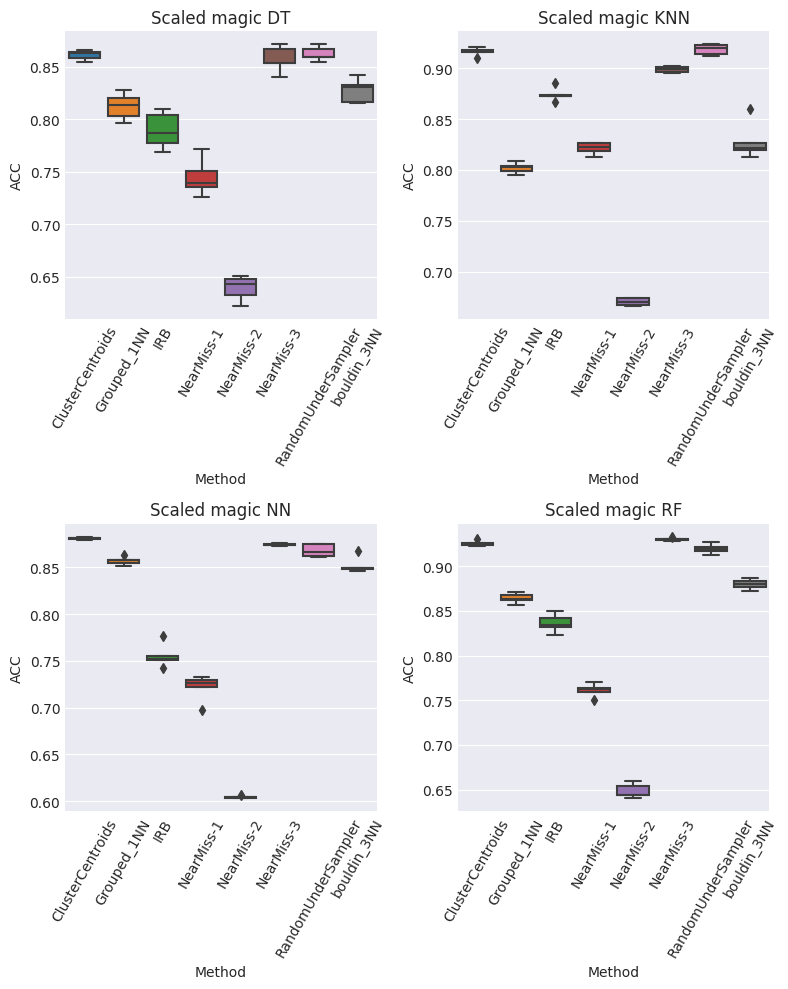

                  Method       ACC  Fold
2592    ClusterCentroids  1.000000     1
3288    ClusterCentroids  1.000000     5
2752    ClusterCentroids  1.000000     2
3260    ClusterCentroids  1.000000     4
3008    ClusterCentroids  1.000000     3
2720         Grouped_1NN  0.930233     1
3424         Grouped_1NN  0.931034     5
2816         Grouped_1NN  0.953488     2
3252         Grouped_1NN  1.000000     4
2996         Grouped_1NN  1.000000     3
7242                 IRB  1.000000     3
7226                 IRB  1.000000     2
7210                 IRB  1.000000     1
7278                 IRB  1.000000     4
7298                 IRB  1.000000     5
2760          NearMiss-1  0.779070     2
3024          NearMiss-1  1.000000     3
2736          NearMiss-1  0.790698     1
3280          NearMiss-1  0.965517     5
3152          NearMiss-1  0.816092     4
2716          NearMiss-2  1.000000     1
3368          NearMiss-2  1.000000     5
3248          NearMiss-2  1.000000     4
3052          Ne

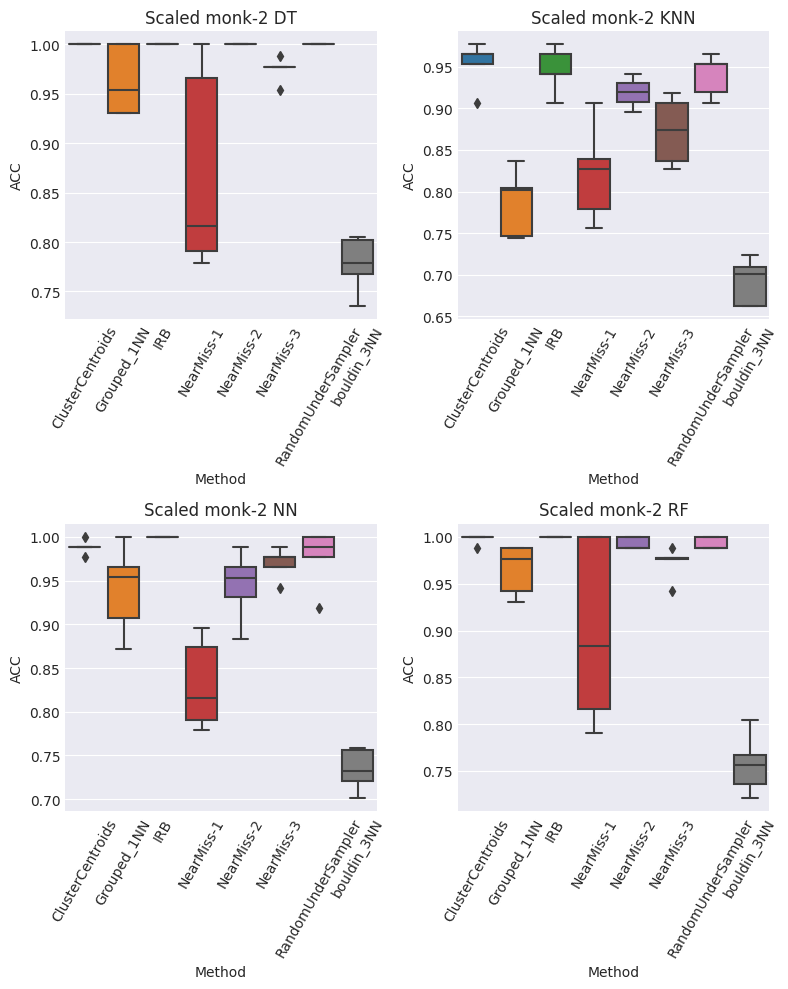

                  Method       ACC  Fold
4100    ClusterCentroids  0.720779     4
3580    ClusterCentroids  0.771242     1
3868    ClusterCentroids  0.772727     3
3644    ClusterCentroids  0.764706     2
4144    ClusterCentroids  0.759740     5
4152         Grouped_1NN  0.577922     5
4016         Grouped_1NN  0.662338     4
3560         Grouped_1NN  0.673203     1
3928         Grouped_1NN  0.649351     3
3772         Grouped_1NN  0.705882     2
7382                 IRB  0.629870     4
7414                 IRB  0.759740     5
7350                 IRB  0.823529     2
7322                 IRB  0.751634     1
7374                 IRB  0.785714     3
3728          NearMiss-1  0.830065     2
3800          NearMiss-1  0.740260     3
3524          NearMiss-1  0.777778     1
4216          NearMiss-1  0.733766     5
3992          NearMiss-1  0.681818     4
3980          NearMiss-2  0.740260     4
4276          NearMiss-2  0.681818     5
3860          NearMiss-2  0.694805     3
3692          Ne

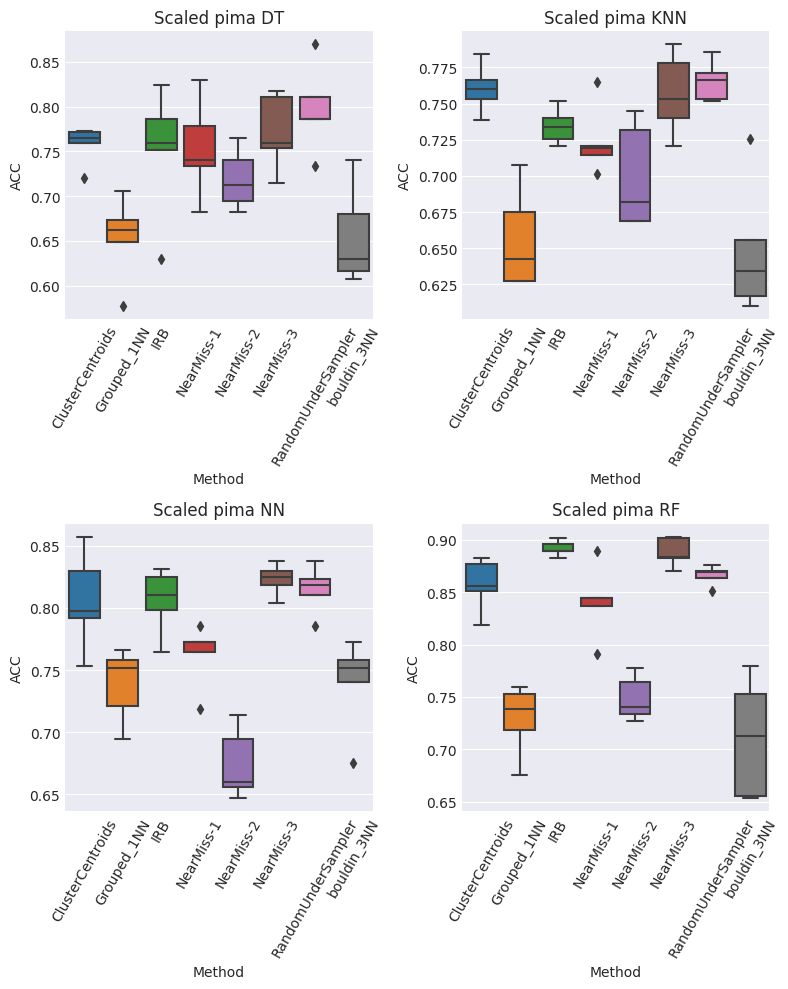

                  Method       ACC  Fold
4833    ClusterCentroids  0.904730     4
4432    ClusterCentroids  0.905405     1
4461    ClusterCentroids  0.912162     2
5065    ClusterCentroids  0.893919     5
4705    ClusterCentroids  0.896622     3
4384         Grouped_1NN  0.857432     1
4541         Grouped_1NN  0.831757     2
5105         Grouped_1NN  0.836486     5
4813         Grouped_1NN  0.875000     4
4729         Grouped_1NN  0.866216     3
7538                 IRB  0.898649     5
7482                 IRB  0.907432     3
7474                 IRB  0.895270     2
7434                 IRB  0.908784     1
7510                 IRB  0.905405     4
4733          NearMiss-1  0.908108     3
4929          NearMiss-1  0.900676     4
4993          NearMiss-1  0.889189     5
4601          NearMiss-1  0.903378     2
4773          NearMiss-2  0.887838     3
4485          NearMiss-2  0.881757     2
4388          NearMiss-2  0.895946     1
4877          NearMiss-2  0.899324     4
5089          Ne

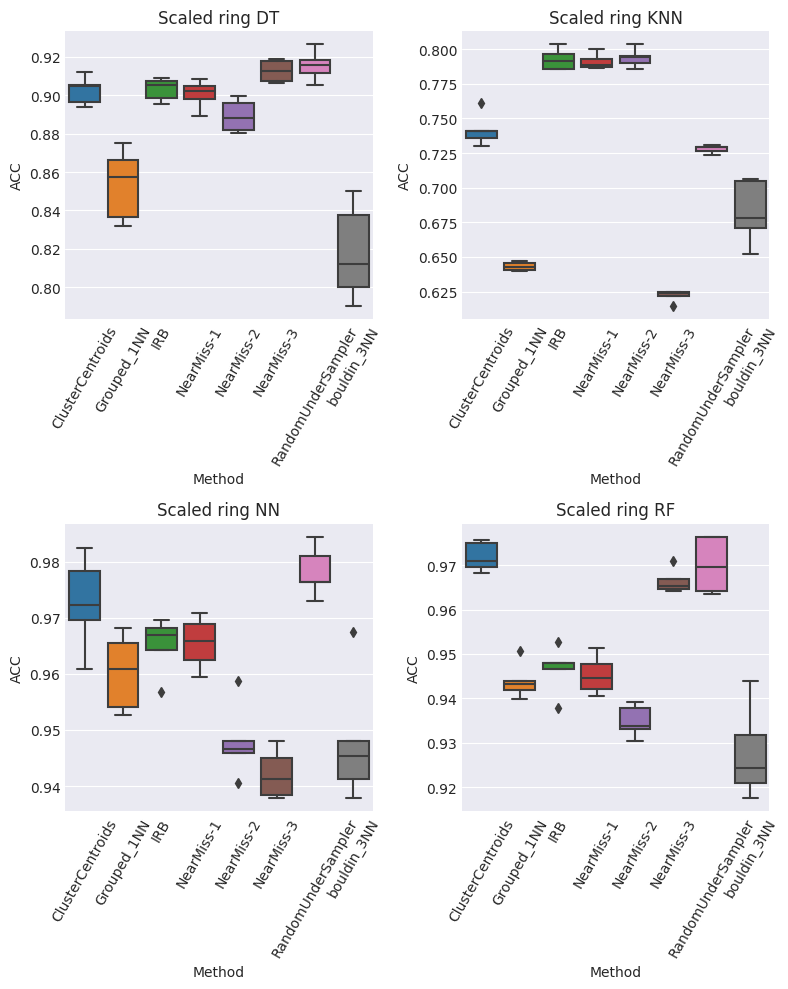

                  Method       ACC  Fold
5145    ClusterCentroids  0.897297     1
5950    ClusterCentroids  0.854730     5
5318    ClusterCentroids  0.862162     2
5630    ClusterCentroids  0.886486     4
5590    ClusterCentroids  0.870946     3
5141         Grouped_1NN  0.819595     1
5878         Grouped_1NN  0.833784     5
5666         Grouped_1NN  0.828378     4
5366         Grouped_1NN  0.816216     2
5542         Grouped_1NN  0.818243     3
7606                 IRB  0.908108     3
7574                 IRB  0.897973     2
7554                 IRB  0.888514     1
7642                 IRB  0.904054     4
7666                 IRB  0.884459     5
5782          NearMiss-1  0.884459     4
5430          NearMiss-1  0.845270     2
5966          NearMiss-1  0.875676     5
5478          NearMiss-1  0.889865     3
5237          NearMiss-1  0.873649     1
5470          NearMiss-2  0.874324     3
5161          NearMiss-2  0.870270     1
5750          NearMiss-2  0.872973     4
5830          Ne

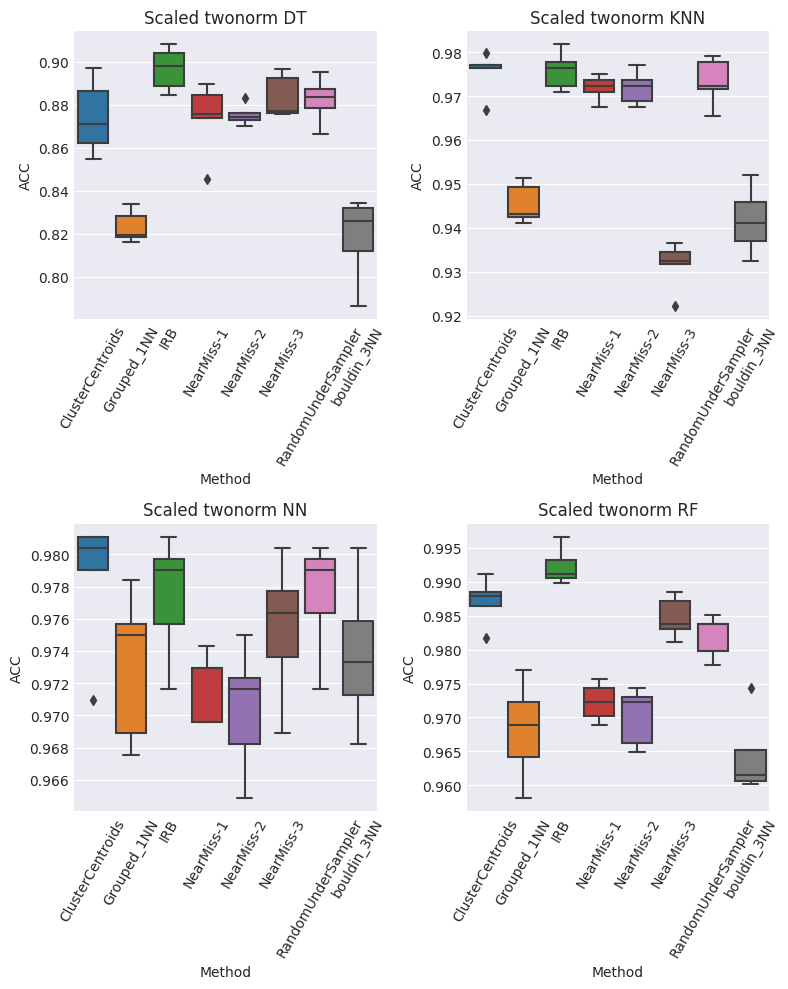

                  Method       ACC  Fold
6818    ClusterCentroids  0.901943     5
6118    ClusterCentroids  0.910185     1
6218    ClusterCentroids  0.909343     2
6534    ClusterCentroids  0.901943     4
6422    ClusterCentroids  0.901018     3
5982         Grouped_1NN  0.826852     1
6758         Grouped_1NN  0.825162     5
6578         Grouped_1NN  0.828862     4
6474         Grouped_1NN  0.821462     3
6294         Grouped_1NN  0.816836     2
7718                 IRB  0.780759     3
7698                 IRB  0.782609     2
7670                 IRB  0.810185     1
7758                 IRB  0.784459     4
7778                 IRB  0.895467     5
6722          NearMiss-1  0.912118     5
6430          NearMiss-1  0.907493     3
6298          NearMiss-1  0.815911     2
6086          NearMiss-1  0.895370     1
6522          NearMiss-1  0.897317     4
6390          NearMiss-2  0.703978     3
6010          NearMiss-2  0.696296     1
6702          NearMiss-2  0.724329     5
6226          Ne

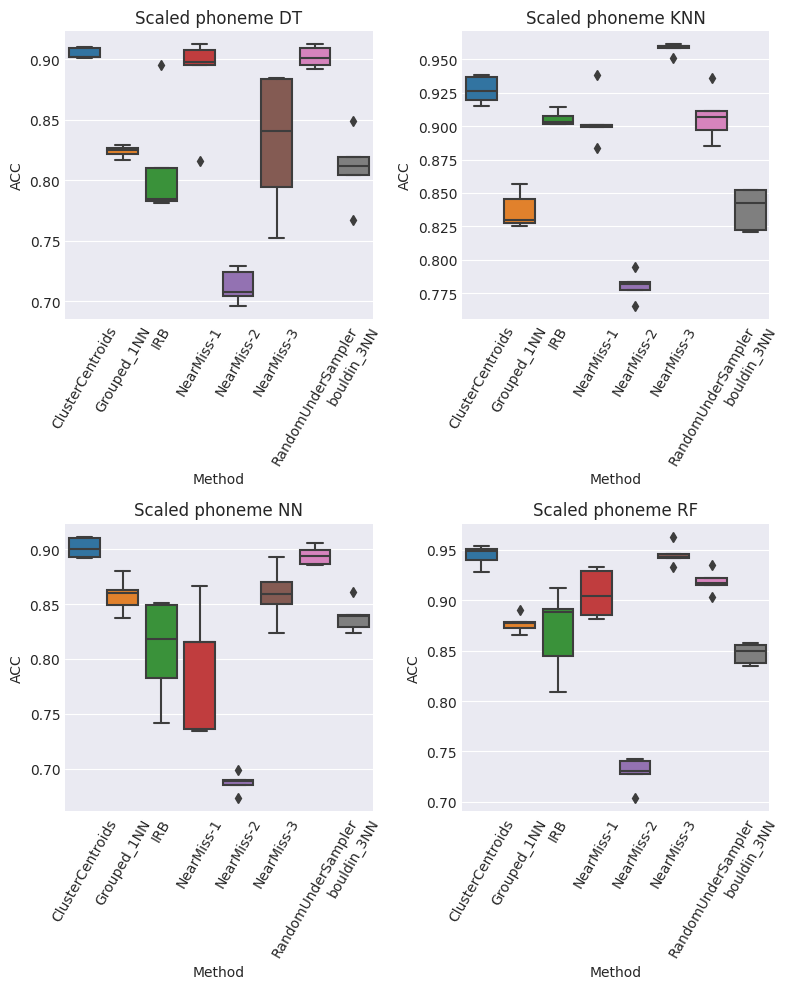

In [183]:
plt.style.use('seaborn-darkgrid')
# plt.title("Acc",fontsize=15)  
# plt.xlabel("Poměr redukce")
# plt.ylabel("Hodnota metriky")

#plt.xscale('log')


# Create a color palette
palette = plt.get_cmap('tab20')
plot_boxplot=True
boxplot_red=0.5
input_files=["magic","banana","bupa", "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
# input_files=["bupa", "magic" ,"monk-2" ,"pima" ,"ring" ,"twonorm" ,"phoneme"]
models=new_format["Model"].unique()
print(models)
for file in input_files:
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8, 10))
    for model,index in zip(models,pd.MultiIndex.from_product([[0,1],[0,1]]).to_list()):
        
        if plot_boxplot:
            boxplot_data=range_data[(range_data["Dataset"]==file) & (range_data["Model"]==model) & (range_data["RED"]==boxplot_red)].drop(columns=["Dataset","Model","RED"]).sort_values(by=["Method"])
            print(boxplot_data)
            #medians=boxplot_data.groupby(["Method"]).median().sort_values(by=["ACC"])
            sns.boxplot(data=boxplot_data,x="Method",y="ACC", ax=axes[index[0]][index[1]])
            axes[index[0]][index[1]].set_xticklabels(axes[index[0]][index[1]].get_xticklabels(), rotation=60)
        else:
            plot_data=new_format[new_format["Dataset"]==file]
            plot_data=plot_data[plot_data["Model"]==model].drop(columns=["Model"])
            #print(plot_data)
            plot_data=plot_data.pivot(columns='Method',index='RED',values="ACC").reset_index()
            #print(plot_data)
            #plot_data.fillna(plot_data['old'][0],inplace=True)
            names=plot_data.drop("RED", axis=1).columns
            plot_data.loc[0,names] = plot_data['Old'][0]
            plot_data.pop("Old")
            #plot_data=plot_data.sort_values(by=["RED"])
            #print(plot_data)
            num=0
            
            
            for column in plot_data.drop('RED', axis=1):
                num+=1
                #axes[index[0]][index[1]]
                fin_data=plot_data[plot_data[column].notnull()]
                #print(fin_data)
                axes[index[0]][index[1]].plot(fin_data['RED'], fin_data[column], marker='o',color=palette(num), linewidth=1, alpha=0.9, label=column)
        axes[index[0]][index[1]].title.set_text("Scaled "+file+" "+model)
        #axes[index[0]][index[1]].autoscale(enable=True, axis='x', tight=True)
        
        
        #     #plt.plot(new_format['ratio'], new_format[column], marker='o',color=palette(num), linewidth=1, alpha=0.9, label=column)
    #plt.title("Acc "+file,fontsize=15)  
    plt.tight_layout()
    if plot_boxplot:
        
        plt.savefig(f'{data_dir}/reduction_survey_results/averaged_gridsearch/averaged_IRB_{file}_boxplot_{boxplot_red}.png',bbox_inches='tight',dpi=300)
        pass
    else:
        plt.legend(bbox_to_anchor=(1.02, 1),loc='lower left',ncol=1)
        plt.savefig(f'{data_dir}/reduction_survey_results/averaged_gridsearch/averaged_IRB_{file}.png',bbox_inches='tight',dpi=300)
    plt.show()

In [169]:
print(new_format[new_format["Dataset"]=="magic"].to_string())   

    Dataset              Method Model   RED       ACC
296   magic    ClusterCentroids    DT   0.5  0.783649
297   magic    ClusterCentroids    DT   0.6  0.780442
298   magic    ClusterCentroids    DT   0.7  0.789485
299   magic    ClusterCentroids    DT   0.8  0.777550
300   magic    ClusterCentroids    DT   0.9  0.778286
301   magic    ClusterCentroids    DT  0.95  0.774606
302   magic    ClusterCentroids   KNN   0.5  0.828076
303   magic    ClusterCentroids   KNN   0.6  0.828970
304   magic    ClusterCentroids   KNN   0.7  0.828286
305   magic    ClusterCentroids   KNN   0.8  0.824869
306   magic    ClusterCentroids   KNN   0.9  0.824027
307   magic    ClusterCentroids   KNN  0.95  0.823028
308   magic    ClusterCentroids    NN   0.5  0.867981
309   magic    ClusterCentroids    NN   0.6  0.869295
310   magic    ClusterCentroids    NN   0.7  0.864458
311   magic    ClusterCentroids    NN   0.8  0.856625
312   magic    ClusterCentroids    NN   0.9  0.853523
313   magic    ClusterCentro

Overall boxplots

In [184]:
barplot_data=new_format.drop(columns=["Model","RED"]).groupby(["Dataset","Method"]).mean().reset_index()
barplot_data#.sort_values(by=["Dataset","ACC"],inplace=True) 

Dataset              Method       ACC
0    banana    ClusterCentroids  0.883381
1    banana         Grouped_1NN  0.861887
2    banana                 IRB  0.663813
3    banana          NearMiss-1  0.849686
4    banana          NearMiss-2  0.717642
..      ...                 ...       ...
67  twonorm          NearMiss-2  0.921205
68  twonorm          NearMiss-3  0.913785
69  twonorm                 Old  0.941689
70  twonorm  RandomUnderSampler  0.938788
71  twonorm         bouldin_3NN  0.906492

[72 rows x 3 columns]

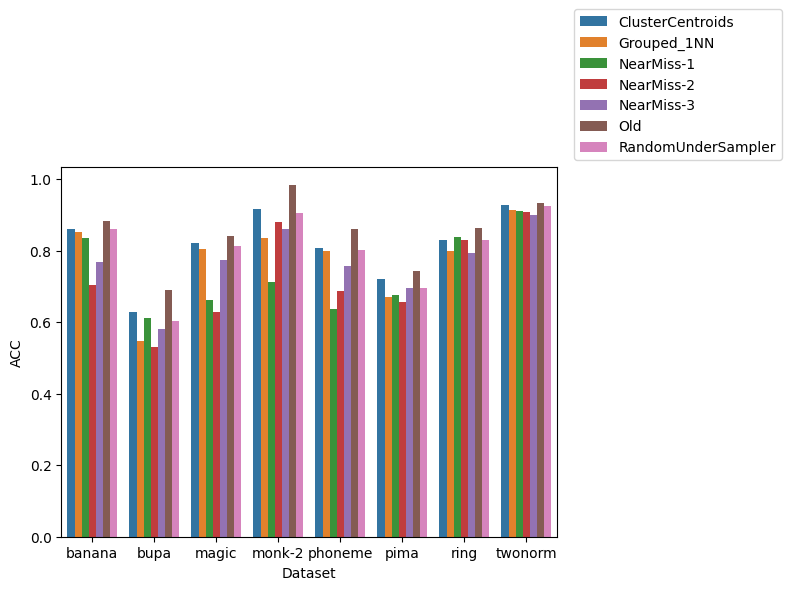

In [211]:
sns.barplot(data=barplot_data,x="Dataset",y="ACC",hue="Method")
plt.legend(bbox_to_anchor=(1.02, 1),loc='lower left',ncol=1)

In [212]:
scatter_data=barplot_data.drop(columns=["Dataset"]).groupby(["Method"]).mean().reset_index()
scatter_data.sort_values(by=["ACC"],inplace=True)

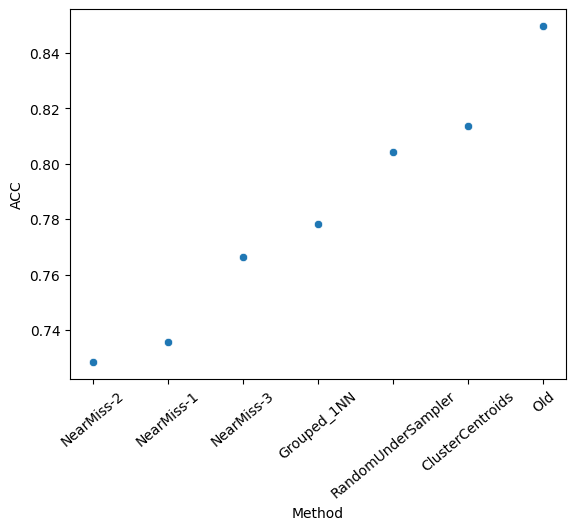

In [213]:
sns.scatterplot(data=scatter_data,x="Method",y="ACC")
# rotate y labels   
plt.xticks(rotation=40)
plt.savefig(f'{data_dir}/reduction_survey_results/averaged/averaged_scatterplot.png',bbox_inches='tight',dpi=300)

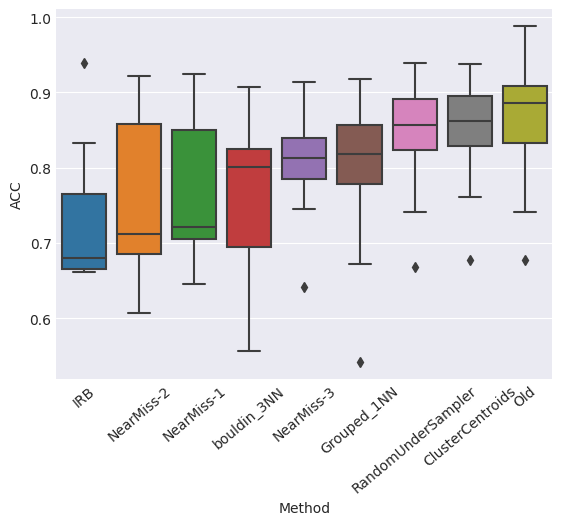

In [185]:
boxplot_data=barplot_data.drop(columns=["Dataset"])
medians=boxplot_data.groupby(["Method"]).median().sort_values(by=["ACC"])
#print(medians)
# boxplots sorted by median
sns.boxplot(data=boxplot_data,x="Method",y="ACC",order=medians.index)
plt.xticks(rotation=40)
# save figure
plt.savefig(f'{data_dir}/reduction_survey_results/averaged_gridsearch/averaged_IRB_boxplot.png',bbox_inches='tight',dpi=300)

In [215]:
plot_data=new_format[new_format["RED"]=="0.6"].drop(columns=["Model","RED"]).groupby(["Dataset","Method"]).mean().reset_index()

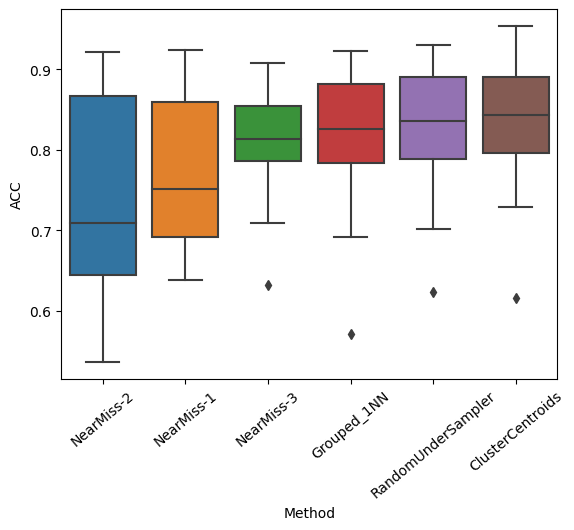

In [216]:
boxplot_data=plot_data.drop(columns=["Dataset"])
medians=boxplot_data.groupby(["Method"]).median().sort_values(by=["ACC"])
#print(medians)
# boxplots sorted by median
sns.boxplot(data=boxplot_data,x="Method",y="ACC",order=medians.index)
plt.xticks(rotation=40)
# save figure
plt.savefig(f'{data_dir}/reduction_survey_results/averaged/averaged_boxplot0.6.png',bbox_inches='tight',dpi=300)

### time comparation

In [186]:
# load data
times_data=pd.read_csv(f"{reduced_data_dir}/ser_times.csv")

In [187]:
times_data

time method  fold  dataset  reduction
0     2.778211    IRB     5   banana       0.50
1     2.736092    IRB     5   banana       0.40
2     2.753826    IRB     5   banana       0.30
3     2.768173    IRB     5   banana       0.20
4     2.769834    IRB     5   banana       0.10
...        ...    ...   ...      ...        ...
1915  2.873785    IRB     1  phoneme       0.40
1916  2.866433    IRB     1  phoneme       0.30
1917  2.860122    IRB     1  phoneme       0.20
1918  2.855618    IRB     1  phoneme       0.10
1919  2.846294    IRB     1  phoneme       0.05

[1920 rows x 5 columns]

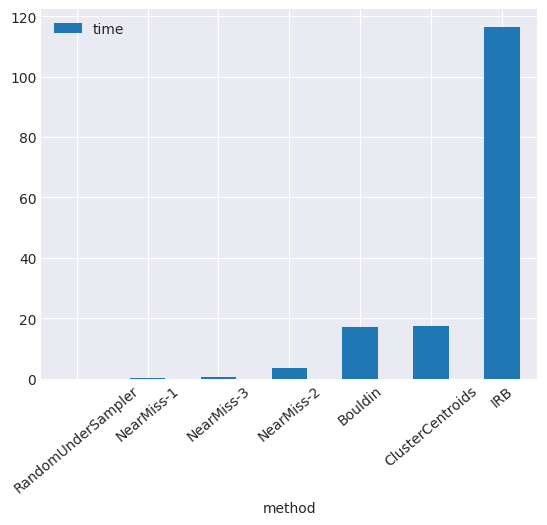

In [188]:
barplot_data=times_data.drop(columns=["fold","dataset","reduction"]).groupby(["method"]).mean().reset_index()
barplot_data=barplot_data.sort_values(by=["time"])
barplot_data.plot.bar(x="method",y="time")
plt.xticks(rotation=40)
plt.savefig(f'{data_dir}/reduction_survey_results/averaged_gridsearch/averaged_times.png',bbox_inches='tight',dpi=300)